<a href="https://colab.research.google.com/github/sarithamiryala/DeepLearningClassifier/blob/main/sugarcane_swin_transformer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
akilesh253_sugarcane_plant_diseases_dataset_path = kagglehub.dataset_download('akilesh253/sugarcane-plant-diseases-dataset')

print('Data source import complete.')


In [ ]:
!pip install split-folders

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from torchvision import datasets, transforms
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from transformers import ViTForImageClassification, ViTFeatureExtractor
from tqdm import tqdm

In [ ]:
# Check if CUDA is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cuda


In [ ]:
import splitfolders

input_folder = "/kaggle/input/sugarcane-plant-diseases-dataset/Sugarcane_leafs"
splitfolders.ratio(input_folder, output="/kaggle/working/sugarcanedisease", seed=42, ratio=(0.7, 0.15, 0.15), group_prefix=None)

Copying files: 19926 files [00:49, 405.61 files/s] 


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMG_SIZE = (256, 256)
BATCH_SIZE = 16

train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=90,
                                   horizontal_flip=True,
                                   vertical_flip=True,
                                   zoom_range=0.2)

val_test_datagen = ImageDataGenerator(rescale=1./255)


#----------------------------------------

train_generator = train_datagen.flow_from_directory('/kaggle/working/sugarcanedisease/train',
                                                    target_size=IMG_SIZE,
                                                    batch_size=BATCH_SIZE,
                                                    class_mode='categorical')

val_generator = val_test_datagen.flow_from_directory('/kaggle/working/sugarcanedisease/val',
                                                target_size=IMG_SIZE,
                                                batch_size=BATCH_SIZE,
                                                class_mode='categorical')

test_generator = val_test_datagen.flow_from_directory('/kaggle/working/sugarcanedisease/test',
                                                  target_size=IMG_SIZE,
                                                  batch_size=BATCH_SIZE,
                                                  class_mode='categorical',
                                                  shuffle=False)

Found 13946 images belonging to 6 classes.
Found 2986 images belonging to 6 classes.
Found 2994 images belonging to 6 classes.


In [ ]:
import os
import torch
from torchvision import datasets, transforms

# Define data directories
data_dir = '/kaggle/working/sugarcanedisease'
train_dir = os.path.join(data_dir, 'train')
val_dir = os.path.join(data_dir, 'val')
test_dir = os.path.join(data_dir, 'test')

# Define image size and batch size
IMG_SIZE = (224, 224)
BATCH_SIZE = 16

# Define data transformations
# Corresponding to Keras ImageDataGenerator parameters
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(IMG_SIZE),
        transforms.RandomRotation(90),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.RandomAffine(degrees=0, scale=(0.8, 1.2)),
        transforms.ToTensor(),
        # No need for rescale=1./255 because ToTensor() does that
    ]),
    'val': transforms.Compose([
        transforms.Resize(IMG_SIZE),
        transforms.ToTensor(),
        # No need for rescale=1./255 because ToTensor() does that
    ]),
    'test': transforms.Compose([
        transforms.Resize(IMG_SIZE),
        transforms.ToTensor(),
        # No need for rescale=1./255 because ToTensor() does that
    ]),
}

# Create datasets using ImageFolder
train_dataset = datasets.ImageFolder(train_dir, transform=data_transforms['train'])
val_dataset = datasets.ImageFolder(val_dir, transform=data_transforms['val'])
test_dataset = datasets.ImageFolder(test_dir, transform=data_transforms['test'])

# Create DataLoaders
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

In [ ]:
# Print dataset sizes
print(f'Training dataset size: {len(train_dataset)}')
print(f'Validation dataset size: {len(val_dataset)}')

Training dataset size: 13946
Validation dataset size: 2986


In [ ]:
train_dataset.classes

['BacterialBlights', 'Healthy', 'Mosaic', 'RedRot', 'Rust', 'Yellow']

In [ ]:
num_classes = len(train_dataset.classes)

Load the Swin Transformer model:

In [ ]:
from transformers import SwinForImageClassification, AutoConfig

# Choose the pre-trained Swin model; options include:
# 'microsoft/swin-tiny-patch4-window7-224'
# 'microsoft/swin-base-patch4-window7-224'
model_name = 'microsoft/swin-base-patch4-window7-224'

# Load the pre-trained model configuration
config = AutoConfig.from_pretrained(model_name)
config.num_labels = num_classes  # Set the number of output labels

# Load the Swin Transformer model
model = SwinForImageClassification.from_pretrained(model_name, config=config,ignore_mismatched_sizes=True )

# Move the model to the device (GPU or CPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Print the model architecture
print(model)

Some weights of SwinForImageClassification were not initialized from the model checkpoint at microsoft/swin-base-patch4-window7-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([6]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 1024]) in the checkpoint and torch.Size([6, 1024]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


SwinForImageClassification(
  (swin): SwinModel(
    (embeddings): SwinEmbeddings(
      (patch_embeddings): SwinPatchEmbeddings(
        (projection): Conv2d(3, 128, kernel_size=(4, 4), stride=(4, 4))
      )
      (norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): SwinEncoder(
      (layers): ModuleList(
        (0): SwinStage(
          (blocks): ModuleList(
            (0): SwinLayer(
              (layernorm_before): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
              (attention): SwinAttention(
                (self): SwinSelfAttention(
                  (query): Linear(in_features=128, out_features=128, bias=True)
                  (key): Linear(in_features=128, out_features=128, bias=True)
                  (value): Linear(in_features=128, out_features=128, bias=True)
                  (dropout): Dropout(p=0.0, inplace=False)
                )
                (output): SwinSelfOutput(

In [ ]:
criterion = nn.CrossEntropyLoss()

# Use only trainable parameters for the optimizer
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# Define a learning rate scheduler (optional)
scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

In [ ]:
def train(model, dataloader, optimizer, criterion):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in tqdm(dataloader, desc='Training'):
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        # Forward pass
        outputs = model(images)
        logits = outputs.logits
        loss = criterion(logits, labels)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        _, preds = torch.max(logits, 1)
        total += labels.size(0)
        correct += (preds == labels).sum().item()

    epoch_loss = running_loss / len(dataloader.dataset)
    epoch_acc = correct / total
    return epoch_loss, epoch_acc

def validate(model, dataloader, criterion):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in tqdm(dataloader, desc='Validation'):
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            logits = outputs.logits
            loss = criterion(logits, labels)

            running_loss += loss.item() * images.size(0)
            _, preds = torch.max(logits, 1)
            total += labels.size(0)
            correct += (preds == labels).sum().item()

    epoch_loss = running_loss / len(dataloader.dataset)
    epoch_acc = correct / total
    return epoch_loss, epoch_acc

#Training Loop

In [ ]:
num_epochs = 10
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(num_epochs):
    print(f'Epoch {epoch+1}/{num_epochs}')

    # Train the model
    train_loss, train_acc = train(model, train_loader, optimizer, criterion)
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)

    print(f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}')

    # Validate the model
    val_loss, val_acc = validate(model, val_loader, criterion)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    print(f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}')

    # Step the scheduler (if defined)
    scheduler.step()

    print('-' * 30)

Epoch 1/10


Training: 100%|██████████| 872/872 [09:08<00:00,  1.59it/s]


Train Loss: 0.3984, Train Acc: 0.8540


Validation: 100%|██████████| 187/187 [00:41<00:00,  4.48it/s]


Val Loss: 0.2637, Val Acc: 0.9002
------------------------------
Epoch 2/10


Training: 100%|██████████| 872/872 [09:07<00:00,  1.59it/s]


Train Loss: 0.2412, Train Acc: 0.9147


Validation: 100%|██████████| 187/187 [00:41<00:00,  4.48it/s]


Val Loss: 0.2146, Val Acc: 0.9267
------------------------------
Epoch 3/10


Training: 100%|██████████| 872/872 [09:07<00:00,  1.59it/s]


Train Loss: 0.1873, Train Acc: 0.9320


Validation: 100%|██████████| 187/187 [00:41<00:00,  4.48it/s]


Val Loss: 0.2232, Val Acc: 0.9159
------------------------------
Epoch 4/10


Training: 100%|██████████| 872/872 [09:07<00:00,  1.59it/s]


Train Loss: 0.1821, Train Acc: 0.9352


Validation: 100%|██████████| 187/187 [00:41<00:00,  4.49it/s]


Val Loss: 0.1438, Val Acc: 0.9468
------------------------------
Epoch 5/10


Training: 100%|██████████| 872/872 [09:06<00:00,  1.59it/s]


Train Loss: 0.1603, Train Acc: 0.9399


Validation: 100%|██████████| 187/187 [00:41<00:00,  4.48it/s]


Val Loss: 0.1244, Val Acc: 0.9565
------------------------------
Epoch 6/10


Training: 100%|██████████| 872/872 [09:07<00:00,  1.59it/s]


Train Loss: 0.0846, Train Acc: 0.9698


Validation: 100%|██████████| 187/187 [00:41<00:00,  4.47it/s]


Val Loss: 0.0862, Val Acc: 0.9642
------------------------------
Epoch 7/10


Training: 100%|██████████| 872/872 [09:07<00:00,  1.59it/s]


Train Loss: 0.0664, Train Acc: 0.9748


Validation: 100%|██████████| 187/187 [00:41<00:00,  4.46it/s]


Val Loss: 0.0885, Val Acc: 0.9665
------------------------------
Epoch 8/10


Training: 100%|██████████| 872/872 [09:07<00:00,  1.59it/s]


Train Loss: 0.0569, Train Acc: 0.9786


Validation: 100%|██████████| 187/187 [00:41<00:00,  4.48it/s]


Val Loss: 0.0801, Val Acc: 0.9685
------------------------------
Epoch 9/10


Training: 100%|██████████| 872/872 [09:07<00:00,  1.59it/s]


Train Loss: 0.0509, Train Acc: 0.9807


Validation: 100%|██████████| 187/187 [00:41<00:00,  4.48it/s]


Val Loss: 0.0825, Val Acc: 0.9709
------------------------------
Epoch 10/10


Training: 100%|██████████| 872/872 [09:07<00:00,  1.59it/s]


Train Loss: 0.0461, Train Acc: 0.9840


Validation: 100%|██████████| 187/187 [00:41<00:00,  4.48it/s]

Val Loss: 0.0866, Val Acc: 0.9668
------------------------------


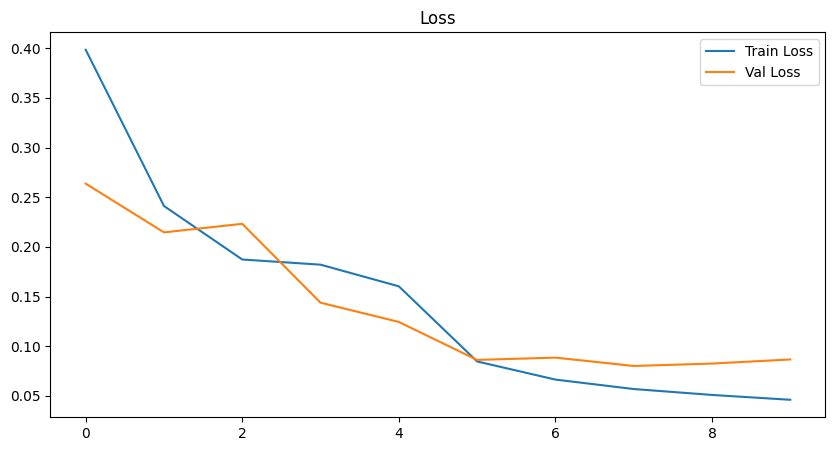

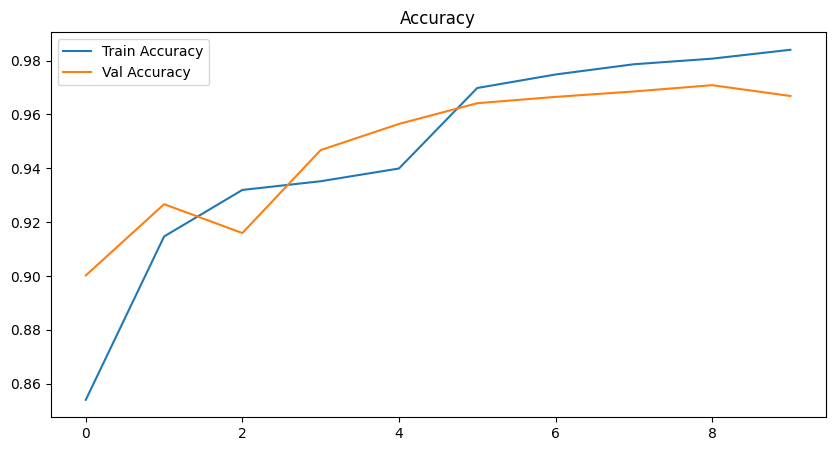

In [ ]:
# Plot training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.legend()
plt.title('Loss')
plt.show()

# Plot training and validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Val Accuracy')
plt.legend()
plt.title('Accuracy')
plt.show()

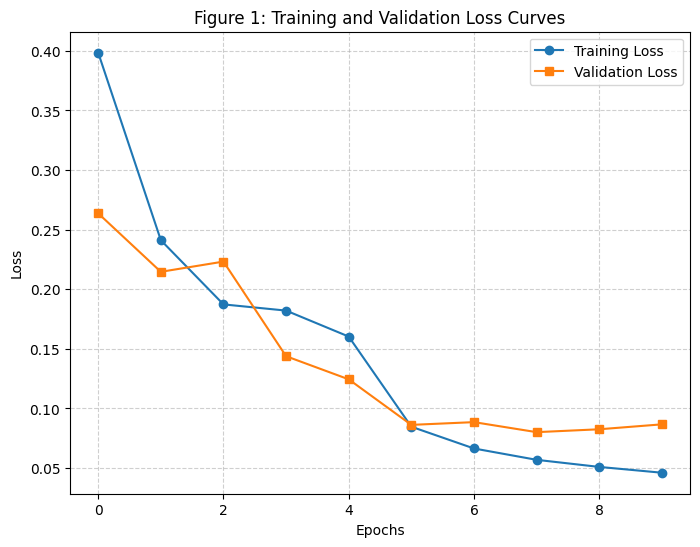

In [ ]:
# Plot training and validation loss
plt.figure(figsize=(8, 6))
plt.plot(train_losses, label='Training Loss', marker='o')
plt.plot(val_losses, label='Validation Loss', marker='s')
plt.title('Figure 1: Training and Validation Loss Curves')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.savefig('training_validation_loss.png')  # Save as an image
plt.show()

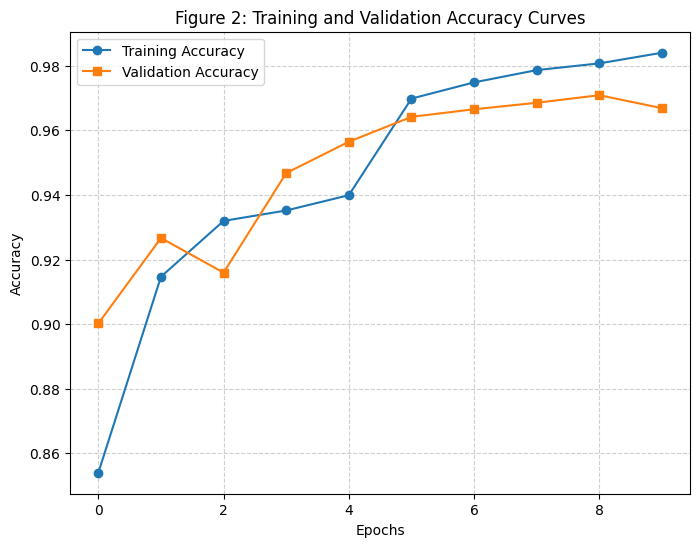

In [ ]:
# Plot training and validation accuracy
plt.figure(figsize=(8, 6))
plt.plot(train_accuracies, label='Training Accuracy', marker='o')
plt.plot(val_accuracies, label='Validation Accuracy', marker='s')
plt.title('Figure 2: Training and Validation Accuracy Curves')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.savefig('training_validation_accuracy.png')  # Save as an image
plt.show()

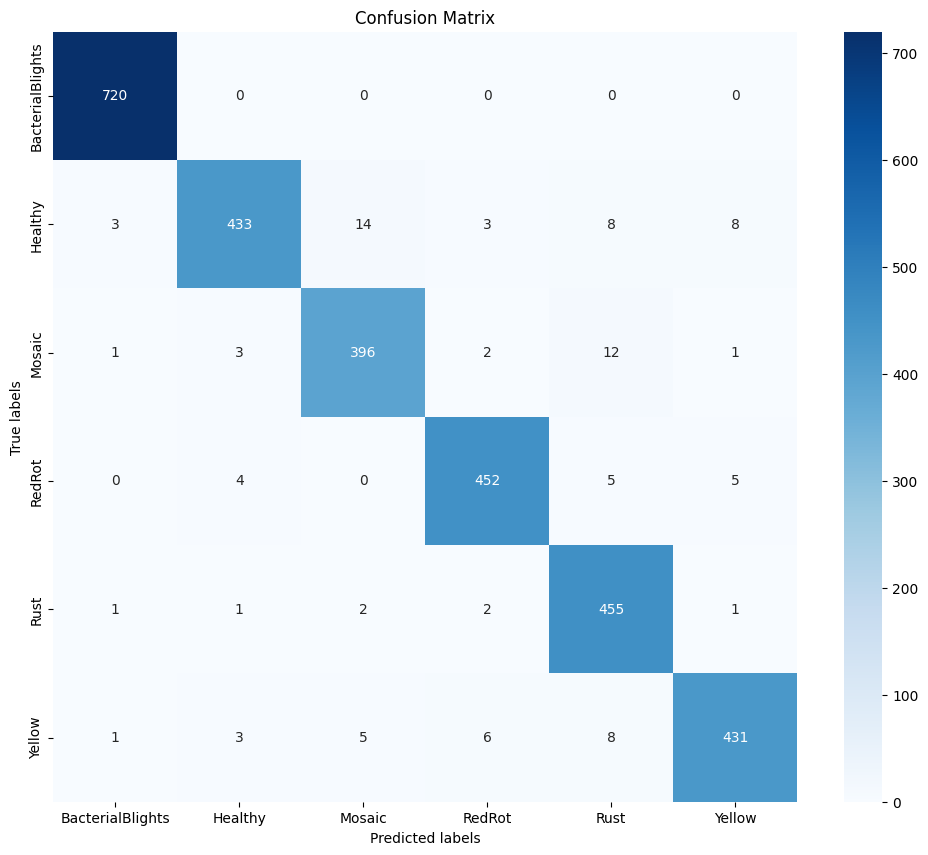

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Collect all the true labels and predicted labels for the validation set
all_labels = []
all_preds = []

model.eval()
with torch.no_grad():
    for inputs, labels in val_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs).logits
        _, preds = torch.max(outputs, 1)
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())

# Calculate the confusion matrix
cm = confusion_matrix(all_labels, all_preds)

# Plot the confusion matrix
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=train_dataset.classes, yticklabels=train_dataset.classes)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

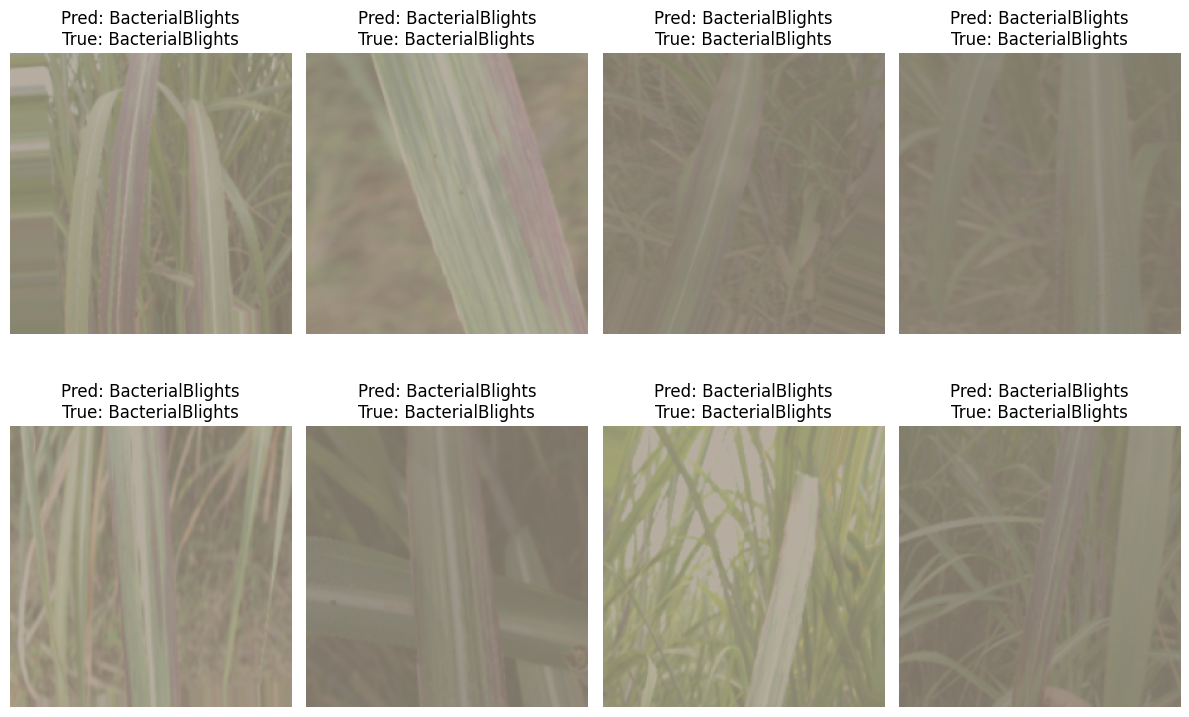

In [ ]:
def imshow(image_tensor, title=None):
    image = image_tensor.permute(1, 2, 0).cpu().numpy()
    mean = np.array([0.485, 0.456, 0.406])
    std  = np.array([0.229, 0.224, 0.225])
    image = std * image + mean  # Unnormalize
    image = np.clip(image, 0, 1)
    plt.imshow(image)
    if title is not None:
        plt.title(title)
    plt.axis('off')

# Get a batch of test data
inputs, labels = next(iter(test_loader))
inputs = inputs.to(device)
labels = labels.to(device)

# Generate predictions
model.eval()
with torch.no_grad():
    outputs = model(inputs)
    logits = outputs.logits
    _, preds = torch.max(logits, 1)

# Plot images with predicted and true labels
plt.figure(figsize=(12, 8))
for idx in range(8):  # Display first 8 images
    ax = plt.subplot(2, 4, idx+1)
    imshow(inputs[idx])
    class_names = train_dataset.classes
    pred_label = class_names[preds[idx]]
    true_label = class_names[labels[idx]]
    ax.set_title(f'Pred: {pred_label}\nTrue: {true_label}')

plt.tight_layout()
plt.show()

In [ ]:
# Save the fine-tuned model weights
torch.save(model.state_dict(), '/kaggle/working/swin_sugarcane_disease_detection.pth')

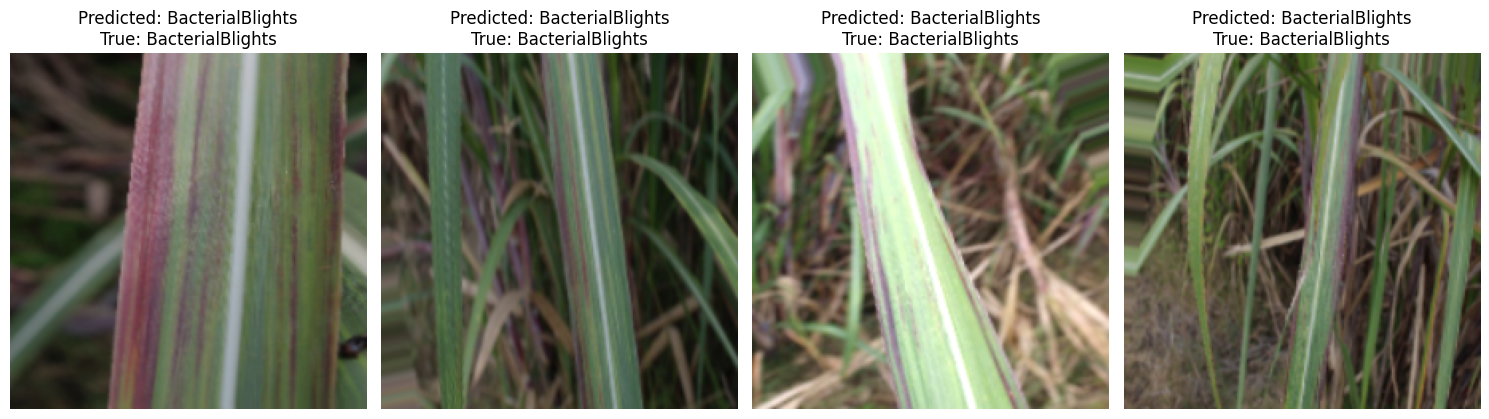

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import torch

# Function to show an image
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.cpu().numpy().transpose((1, 2, 0))
    # Unnormalize if necessary
    # mean = np.array([0.485, 0.456, 0.406])
    # std = np.array([0.229, 0.224, 0.225])
    # inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.axis('off')  # Hide axes for clarity

# Get a batch of validation data
inputs, classes = next(iter(val_loader))

# Move inputs and labels to the device
inputs = inputs.to(device)
classes = classes.to(device)

# Set model to evaluation mode
model.eval()

# Make predictions without tracking gradients
with torch.no_grad():
    # Obtain the outputs from the model
    outputs = model(inputs)

    # **Extract the logits Tensor from the outputs**
    outputs = outputs.logits  # Access the 'logits' attribute

    # Get the predicted classes
    _, preds = torch.max(outputs, 1)

# Move data to CPU for visualization
inputs = inputs.cpu()
classes = classes.cpu()
preds = preds.cpu()

# Get class names
class_names = val_dataset.classes  # Use validation dataset's classes

# Number of images to display
num_images = 4

# Plot the images in the batch, along with predicted and true labels
fig = plt.figure(figsize=(15, 6))
for idx in range(num_images):
    ax = fig.add_subplot(1, num_images, idx+1)
    imshow(inputs[idx])

    # Get class names using class indices
    pred_class = class_names[preds[idx]]
    true_class = class_names[classes[idx]]

    # Set the title with predicted and true labels
    ax.set_title(f"Predicted: {pred_class}\nTrue: {true_class}")
    ax.axis('off')  # Hide axes ticks

plt.tight_layout()
plt.show()

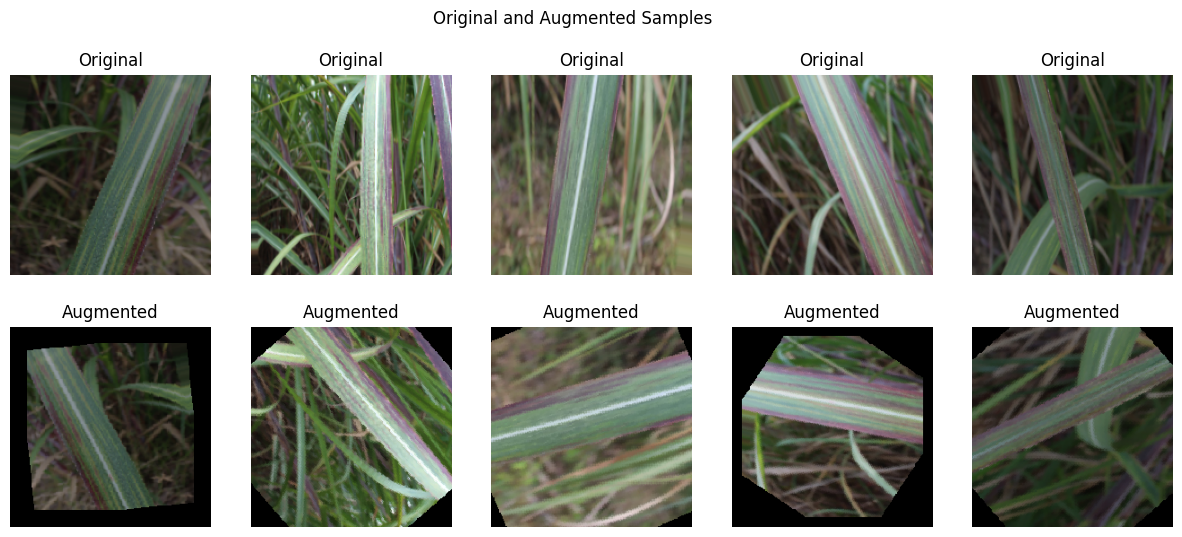

In [ ]:
import os
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from torchvision import datasets
from PIL import Image

# Define image size
IMG_SIZE = (224, 224)

# Define your augmentation transforms (without ToTensor())
aug_transforms = transforms.Compose([
    transforms.Resize(IMG_SIZE),
    transforms.RandomRotation(90),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomAffine(degrees=0, scale=(0.8, 1.2)),
])

# Create an untransformed dataset to access original images
untransformed_dataset = datasets.ImageFolder(train_dir)

# Visualize augmentations for first 5 images
fig, axes = plt.subplots(2, 5, figsize=(15,6))
for idx in range(5):
    img_path, label = untransformed_dataset.samples[idx]
    img = Image.open(img_path).convert('RGB')

    augmented_img = aug_transforms(img)

    # Original image
    axes[0, idx].imshow(img)
    axes[0, idx].axis('off')
    axes[0, idx].set_title('Original')

    # Augmented image
    axes[1, idx].imshow(augmented_img)
    axes[1, idx].axis('off')
    axes[1, idx].set_title('Augmented')

plt.suptitle('Original and Augmented Samples')
plt.show()

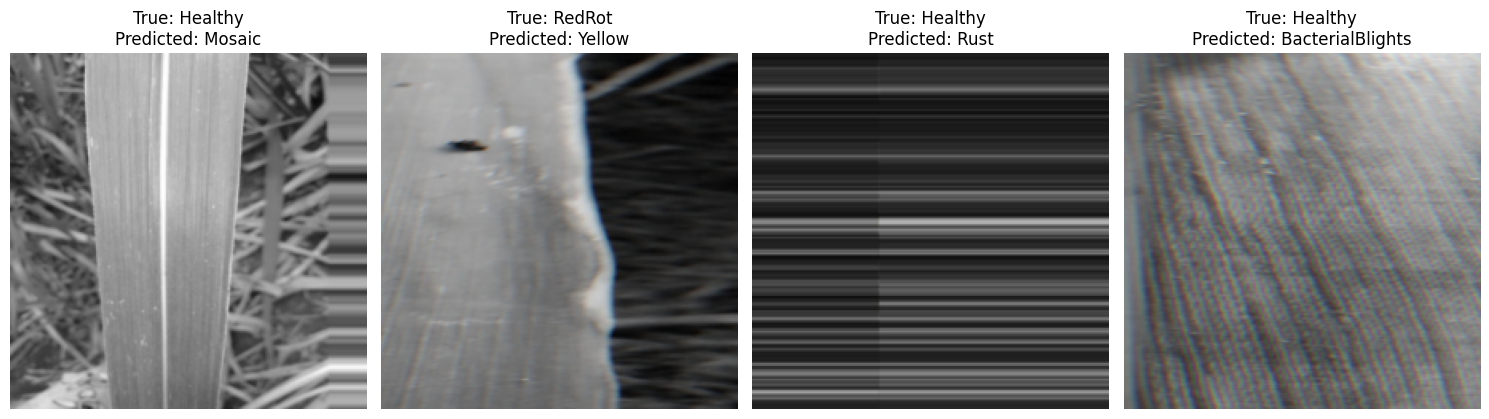

In [ ]:
import random

# Find misclassified indices
misclassified_indices = [i for i, (pred, true) in enumerate(zip(all_preds, all_labels)) if pred != true]
# Randomly select a few misclassified samples
samples = random.sample(misclassified_indices, min(4, len(misclassified_indices)))

fig, axes = plt.subplots(1, len(samples), figsize=(15,5))
for idx, i in enumerate(samples):
    img, label = val_dataset[i]
    axes[idx].imshow(img.permute(1, 2, 0))
    axes[idx].set_title(f'True: {class_names[all_labels[i]]}\nPredicted: {class_names[all_preds[i]]}')
    axes[idx].axis('off')
plt.tight_layout()
plt.show()

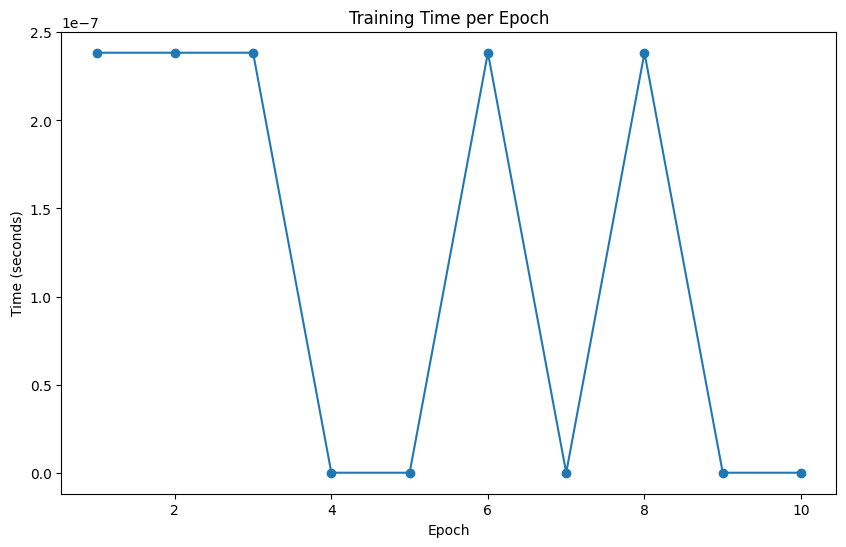

In [ ]:
import time

training_times = []
for epoch in range(num_epochs):
    start_time = time.time()
    # Training code...
    epoch_time = time.time() - start_time
    training_times.append(epoch_time)
# Plotting
plt.figure(figsize=(10,6))
plt.plot(range(1, num_epochs+1), training_times, marker='o')
plt.title('Training Time per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Time (seconds)')
plt.show()